In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, make_scorer
warnings.resetwarnings()

In [2]:

############### Helper functions in case of debugging/data introspection############

def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

def transpose_for_separable2d(splits, train_test_only=False):
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_validate = np.transpose(X_validate, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return transpose_split

    
def true_predict_plot(y_true, y_naive, y_predict, title='', suptitle='', scale=None,s=None):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)
    plt.show()
    return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries, scale=None):
    
    # plot residuals in addition to the residual per country as
    # line plot
    fig, axes = plt.subplots(1, 2, figsize=(20,5), sharey=True)
    (ax1,ax2) = axes.flatten()
    xrange = range(len(y_true))
    if scale=='log':
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax1)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax2)
    else:
        residual_plot(y_true,y_naive, ax=ax1)
        residual_plot(y_true,y_predict, ax=ax2)
#     fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('')
    ax2.set_title('')
    ax1.set_ylabel('Residual')
    ax2.set_ylabel('Residual')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None



def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]

        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)

        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def flatten_Xy(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat )
    return flat_splits

def model_analysis(y_true, y_naive, y_predict, n_countries, title='',suptitle='',figname=None, scale=None, s=None):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    # compute scores 
    mse_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_naive, r2_predict))

    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    (ax1,ax2,ax3,ax4) = axes.flatten()
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    
    ax1.text(0.0, ymax,'$MSE$ = {}'.format(np.round(mse_naive,3)),fontsize=14)
    ax1.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_naive,3)),fontsize=14)
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')
             
    ax2.text(0.0, ymax,'$MSE$ = {}'.format(np.round(mse_predict,3)),fontsize=14)
    ax2.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_predict,3)),fontsize=14)
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)

    
    xrange = range(len(y_true))
    if scale=='log':
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    ax3.set_title('')
    ax4.set_title('')
    ax3.set_ylabel('Residual')
    ax4.set_ylabel('Residual')
    ax3.grid(True)
    ax4.grid(True)
    
    if figname is not None:
        plt.savefig(figname, bbox_inches='tight')
        
    plt.show()
    return None


def normalize_Xy(splits, feature_range=(0., 1.0), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    Normalize with respect to some absolute max, just choose 2*absolute max of training set. 

    """
    
    min_, max_ = feature_range
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    feature_minima = X_train[:,:,:,:].min((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_maxima = 2*X_train[:,:,:,:].max((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_denominator = feature_maxima-feature_minima
    # get the shape of each split's array, so that array arithmetic can be done. 
    train_tile_shape = np.array(np.array(X_train.shape)/np.array(feature_maxima.shape),int)
    validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(feature_maxima.shape),int)
    test_tile_shape = np.array(np.array(X_test.shape)/np.array(feature_maxima.shape),int)

    # using X - X_min / (X_max-X_min). Form denominator
    train_denominator = np.tile(feature_denominator, train_tile_shape)
    validate_denominator = np.tile(feature_denominator, validate_tile_shape)
    test_denominator = np.tile(feature_denominator, test_tile_shape)
    
    # and then the minima.
    train_minima = np.tile(feature_minima,train_tile_shape)
    validate_minima = np.tile(feature_minima,validate_tile_shape)
    test_minima = np.tile(feature_minima,test_tile_shape)
    
    # factor of 1/max_ accounts for absolute maximum that is outside of the data (i.e. potential future values). 
    X_train_scaled = (max_-min_)*(X_train - train_minima)/train_denominator
    X_validate_scaled = (max_-min_)*(X_validate - validate_minima)/validate_denominator
    X_test_scaled = (max_-min_)*(X_test - test_minima)/test_denominator

    
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 
    scaling_arrays =  (feature_maxima, feature_minima, feature_denominator)

    return scaled_splits, scaling_arrays

In [52]:
# Import cleaned data produced by other notebook. 
data = pd.read_csv('cnn_data.csv',index_col=0)

Use the same data as the other models, the 

In [53]:
data = pd.read_csv('regression_data.csv', index_col=0)
tmp =pd.read_csv('regression_data_full.csv', index_col=0)
# data = pd.concat((data, tmp.loc[:, column_search(tmp,'government_response')]),axis=1)
data = data.drop(columns=['date'])
data = data.drop(columns=column_search(data,'test'))
data = data.drop(columns=column_search(data,'deaths'))
data = data.drop(columns=column_search(data,'recovered'))
# data = data.drop(columns=column_search(data,'log'))
data = data.drop(columns=column_search(data,'std'))

In [56]:
data

,location,time_index,days_since_first_case,new_cases_per_million,log_new_cases_per_million,government_response_index,new_cases_per_million_rolling_mean_3,log_new_cases_per_million_rolling_mean_3,government_response_index_rolling_mean_3,new_cases_per_million_rolling_mean_7,log_new_cases_per_million_rolling_mean_7,government_response_index_rolling_mean_7,new_cases_per_million_rolling_mean_14,log_new_cases_per_million_rolling_mean_14,government_response_index_rolling_mean_14
0,Afghanistan,0,0,0.000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00
1,Afghanistan,1,0,0.000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00
2,Afghanistan,2,0,0.000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00
3,Afghanistan,3,0,0.000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00
4,Afghanistan,4,0,0.000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26713,Zimbabwe,178,98,0.673,0.514618,58.97,0.807333,0.561723,58.97,0.788143,0.545518,58.97,1.047714,0.633358,58.97
26714,Zimbabwe,179,99,0.404,0.339325,58.97,0.830000,0.578272,58.97,0.778571,0.538858,58.97,1.014071,0.612695,58.97
26715,Zimbabwe,180,100,0.404,0.000000,58.97,0.493667,0.284648,58.97,0.807429,0.512574,58.97,0.913143,0.538718,58.97
26716,Zimbabwe,181,101,0.471,0.385942,58.97,0.426333,0.241756,58.97,0.653714,0.434149,58.97,0.927571,0.549269,58.97


# Data
<a id='data'></a>
[Return to table of contents](#toc)

Per the distribution of pandemic starting dates, vast majority of countries have cases by day (time_index) 60. Therefore,
truncate the days before this value and truncate the countries which have no cases as of that date.

Want to include only time windows in which all countries have one confirmed case. Unfortunately this would reduce the amount of data samples. There are choices to be made which keep the most countries but also the most relevant dates. There are 132 countries in the dataset, 121 of these have  

Want the dates where most countries have cases, but the date where *all* countries have dates would dramatically reduce 

Do not use sub-components of the stringency index; also, the new tests per million feature
has differing units between countries and so it will be unreliable. Likewise, the number of new recovered and
deaths per million are time delayed quantities and so they are might not be useful for next-day predictions. 

The data creation is the same as in the notebook ```COVID19_model_prototypes.ipynb```. See that notebook for details. Previously, frame size was set to 28. By setting it to 14, get $14*n_{countries}$ more samples as well as fewer input dimensions such that the number of model parameters will be smaller. This size still captures seasonality as well as the time delayed nature of the pandemic. 

In [63]:
# data = data[data.time_index>=40]
model_data = data.copy().iloc[:, 3:]
modeling_features = ['new_cases_per_million', 'government_response_index', 'log_new_cases_per_million']
model_data = data.copy().loc[:, modeling_features]
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index

frame_size = 28
start_date = frame_size + data.time_index.min()

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [64]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_nn_train, y_nn_train, X_nn_validate, y_nn_validate, X_nn_test, y_nn_test) = scaled_splits
(train_indices, validate_indices, test_indices) = indices

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 154 181


In [65]:
n_countries = data.location.nunique()
n_dates = data.time_index.nunique()
n_features = model_data.columns.size
n_countries, n_dates, n_features

(146, 183, 3)

In [66]:
print(X.shape)
print('There are a total of {} frames'.format(X.shape[0]))
print('There are a total of {} countries'.format(X.shape[1]))
print('There are a total of {} time steps in each frame'.format(X.shape[2]))
print('There are a total of {} features'.format(X.shape[3]))

(155, 146, 28, 3)
There are a total of 155 frames
There are a total of 146 countries
There are a total of 28 time steps in each frame
There are a total of 3 features


Quick check that I'm still splitting the data correctly

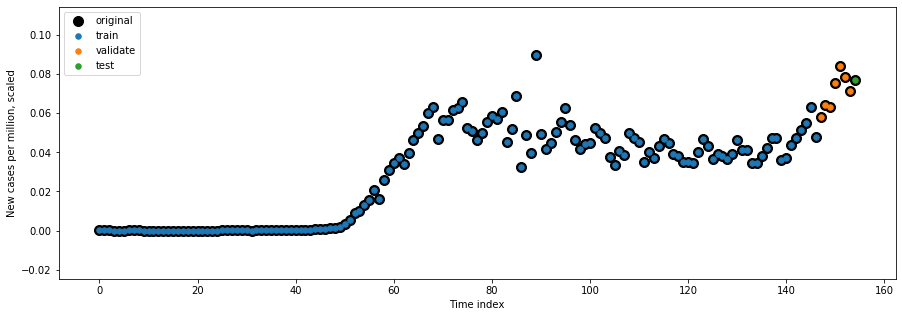

In [9]:
X_scaled_tmp = np.concatenate((X_nn_train,X_nn_validate,X_nn_test), axis=0)

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.scatter(range(len(X_scaled_tmp)), X_scaled_tmp[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=100,color='k', label='original')
ax.scatter(range(len(scaled_splits[0])), scaled_splits[0][:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30, label='train')
ax.scatter(range(len(scaled_splits[0]), len(scaled_splits[0])+len(scaled_splits[2])), scaled_splits[2][:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30, label='validate')
ax.scatter(range(len(scaled_splits[0])+len(scaled_splits[2]), len(X)), X_nn_test[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30, label='test')
plt.legend()
plt.ylabel('New cases per million, scaled')
plt.xlabel('Time index')
plt.savefig('nn_train_test_split.jpg', bbox_inches='tight')
_ = plt.show()


Flatten and produce the naive baseline quantities.

In [10]:
flat_splits = flatten_Xy(scaled_splits)
(X_nn_train_model,y_nn_train_model,X_nn_validate_model,
 y_nn_validate_model,X_nn_test_model,y_nn_test_model) = flat_splits
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

Create the combinations of hyperparameters to search for the best combination. Note that when this is a high dimensional test, the cross-validation is over single seeds.

In [11]:
epochs_list = [50,75,100,125,150]
batch_size_list = [1024]
first_layer_output_dimension_list = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
parameter_combinations = list(itertools.product(epochs_list, batch_size_list, first_layer_output_dimension_list))

So that redundant, time consuming calculations are not performed every notebook run, create a crude
logging system such that the model is only fit with a certain set of parameters if hasn't been done in the past, as
indicated by the presence of a score in the csv file.

In [12]:
save_filename = 'nn_score_less_training.csv'

if os.path.isfile(save_filename):
    score_logging_df = pd.read_csv(save_filename, index_col=0)
else:
    score_logging_df = pd.DataFrame(np.array(parameter_combinations), 
                                    columns=['epochs','batch_size','first_layer_output_dimension_list'])
    score_logging_df.loc[:, 'mean_squared_error'] = np.nan
    score_logging_df.loc[:, 'mean_absolute_error'] = np.nan
    score_logging_df.loc[:, 'explained_variance'] = np.nan
    score_logging_df.loc[:, 'naive_mean_absolute_error'] = np.nan
    score_logging_df.loc[:, 'naive_explained_variance'] = np.nan
    score_logging_df.loc[:, 'naive_mean_squared_error'] = np.nan

Batch size and epochs are inversely proportional essentially. 

## Neural network model 
<a id='model'></a>
[Return to table of contents](#toc)


The convolution will be with respect to time, specifically the time steps within frames of time of predetermined length. The architecture of the CNN itself is two convolutional layers followed by two dense layers, ending with a ReLU activation layer. The key pieces of information to keep in mind when creating the neural network models are that I need to keep the parameter number small to account for the relatively small number of samples, to include only most important time dependent features and to make sure time ordering is respected.

In [13]:
zero_seeds = [0,1,2]
one_seeds = [3,4,5]
# zero_seeds = [0]
# one_seeds = [3]

In [14]:
for i, hyper_parameters in enumerate(parameter_combinations):
    (epochs, batch_size, first_layer_output_dimension) = hyper_parameters
    mse_list = []
    naive_mse_list = []
    explained_variance_list = []
    naive_explained_variance_list = []
    mae_list = []
    naive_mae_list = []
    if score_logging_df.isna().loc[i,'mean_squared_error']:
        for j in range(len(zero_seeds)):
            nn_input = Input(shape=(np.prod(X_nn_train.shape[2:]),))
            flat = Flatten()(nn_input)
            dense0 = Dense(int(first_layer_output_dimension), 
                            use_bias=False,
                           kernel_initializer=RandomNormal(seed=zero_seeds[j]),
                           )(flat)
            dense1 = Dense(1, 
                            activation='relu',
                            use_bias=False,
                           kernel_initializer=RandomNormal(seed=one_seeds[j]),
                           )(dense0)

            nn = Model(inputs=nn_input, outputs=dense1)
            nn.compile(loss='mse', optimizer=Adam())
            history = nn.fit(X_nn_train_model, y_nn_train_model, epochs=epochs, validation_data=(X_nn_validate_model, y_nn_validate_model), 
                      batch_size=batch_size, verbose=0)

            y_true = y_nn_validate_model.ravel()
            y_predict = nn.predict(X_nn_validate_model).ravel()
            y_naive = y_validate_naive.ravel()

            # mean squared errors
            naive_mse_list.append(mean_squared_error(y_true.ravel(), y_naive.ravel()))
            mse_list.append(mean_squared_error(y_true.ravel(), y_predict))
            # explained variance
            naive_explained_variance_list.append(explained_variance_score(y_true.ravel(), y_naive.ravel()))
            explained_variance_list.append(explained_variance_score(y_true.ravel(), y_predict))
            # mean absolute error
            mae_list.append(mean_absolute_error(y_true.ravel(), y_predict))
            naive_mae_list.append(mean_absolute_error(y_true.ravel(), y_naive.ravel()))

        score_logging_df.loc[i,'naive_mean_squared_error'] =  np.mean(naive_mse_list)
        score_logging_df.loc[i,'mean_squared_error']  = np.mean(mse_list)
        score_logging_df.loc[i,'naive_explained_variance']  = np.mean(naive_explained_variance_list)
        score_logging_df.loc[i,'explained_variance']  = np.mean(explained_variance_list)
        score_logging_df.loc[i,'naive_mean_absolute_error']  =np.mean(naive_mae_list)
        score_logging_df.loc[i,'mean_absolute_error']  = np.mean(mae_list)
        # every time a new score is calculated, overwrite the original file, to save space but also save progress scoring.
        score_logging_df.to_csv(save_filename)
    else:
        pass
    
    print('#',end='')
    if (i % 50 == 0) & i>0:
          print('{} runs completed'.format(str(i)))

##################################################

Look at the parameters and scores of the best model.

In [15]:
score_logging_df.sort_values(by='mean_squared_error').head(10)

,epochs,batch_size,first_layer_output_dimension_list,mean_squared_error,mean_absolute_error,explained_variance,naive_mean_absolute_error,naive_explained_variance,naive_mean_squared_error
49,150,1024,1024,191.660027,6.546602,0.936206,5.934804,0.926058,219.307632
47,150,1024,256,191.937114,6.877868,0.935395,5.934804,0.926058,219.307632
28,100,1024,512,193.239475,6.929315,0.934976,5.934804,0.926058,219.307632
19,75,1024,1024,194.435317,6.747584,0.934963,5.934804,0.926058,219.307632
38,125,1024,512,194.819495,7.025000,0.934894,5.934804,0.926058,219.307632
48,150,1024,512,197.184137,6.627753,0.933698,5.934804,0.926058,219.307632
39,125,1024,1024,197.460978,6.790963,0.934692,5.934804,0.926058,219.307632
29,100,1024,1024,197.990922,6.708627,0.933553,5.934804,0.926058,219.307632
37,125,1024,256,201.236202,6.985624,0.932507,5.934804,0.926058,219.307632
46,150,1024,128,220.141570,7.287776,0.926139,5.934804,0.926058,219.307632


In [16]:
score_logging_df.loc[score_logging_df.mean_squared_error.idxmin(),:]

epochs                                150.000000
batch_size                           1024.000000
first_layer_output_dimension_list    1024.000000
mean_squared_error                    191.660027
mean_absolute_error                     6.546602
explained_variance                      0.936206
naive_mean_absolute_error               5.934804
naive_explained_variance                0.926058
naive_mean_squared_error              219.307632
Name: 49, dtype: float64

Unfortunately this does not beat the naive baseline (the scores are with respect to the validation set).

In [17]:
best_model_parameters = score_logging_df.loc[score_logging_df.mean_squared_error.idxmin(),:].iloc[:3]
print(best_model_parameters)

epochs                                150.0
batch_size                           1024.0
first_layer_output_dimension_list    1024.0
Name: 49, dtype: float64


Try again with a different seed, see if all hope is lost.

In [18]:
X_final_train = np.concatenate((X_nn_train_model, X_nn_validate_model),axis=0)
y_final_train = np.concatenate((y_nn_train_model, y_nn_validate_model),axis=0)

In [19]:
kernel_final_0 = RandomNormal(seed=8)
kernel_final_1 = RandomNormal(seed=42)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
(epochs, batch_size, first_layer_output_dimension) = best_model_parameters
nn_input = Input(shape=(np.prod(X_nn_train.shape[2:]),))
flat = Flatten()(nn_input)
dense0 = Dense(first_layer_output_dimension, 
                use_bias=False,
               kernel_initializer=kernel_final_0,
               )(flat)
dense1 = Dense(1, 
                activation='relu',
                use_bias=False,
              kernel_initializer=kernel_final_1,
               )(dense0)


best_nn = Model(inputs=nn_input, outputs=dense1)
best_nn.compile(loss='mse', optimizer=Adam())


In [21]:
best_nn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112)]             0         
_________________________________________________________________
flatten (Flatten)            (None, 112)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              114688    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1024      
Total params: 115,712
Trainable params: 115,712
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = best_nn.fit(X_final_train, y_final_train, epochs=int(epochs),
                      validation_data=(X_nn_test_model, y_nn_test_model), 
          batch_size=int(batch_size), verbose=0)

## Analysis and conclusion
<a id='conclusion'></a>
[Return to table of contents](#toc)


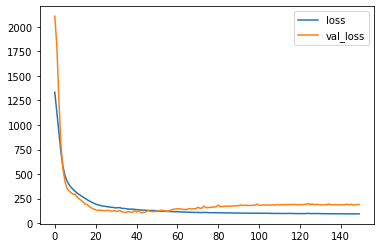

In [23]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

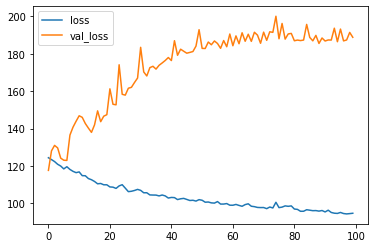

In [24]:
_ = plt.plot(history.history['loss'][-100:], label='loss')
_ = plt.plot(history.history['val_loss'][-100:], label='val_loss')
_ = plt.legend()
_ = plt.show()

Predictions made on the training set (for determining whether or not we overtraining 

There were 0 negative predictions
1-step MSE [Naive, NN model] = [120.41959446037183,94.32335388924092]
1-step R^2 [Naive, NN model] = [0.91597417503742,0.9345280132643536]


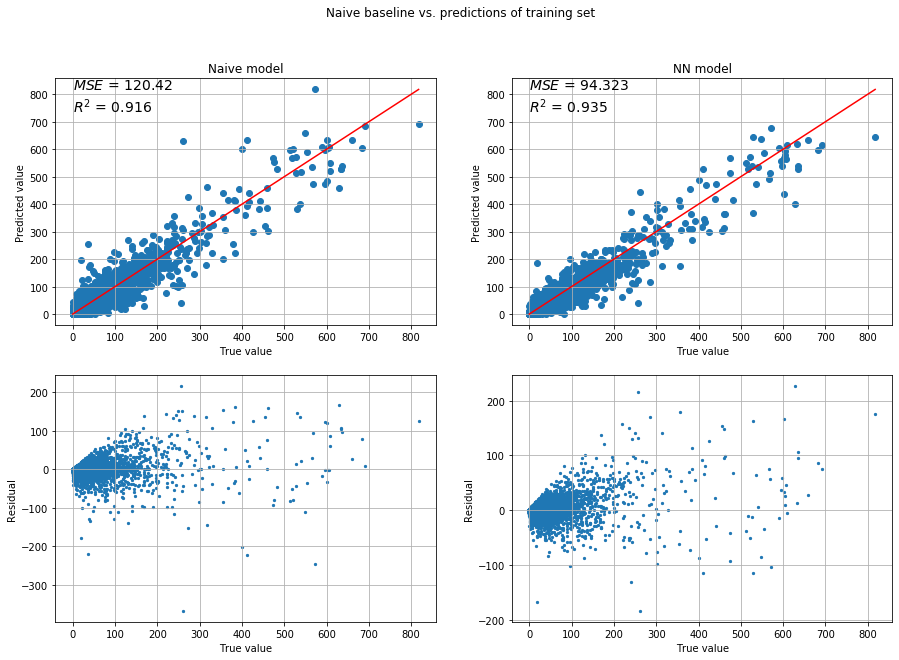

In [25]:
y_true = y_final_train.ravel()
y_naive = np.concatenate((y_train_naive, y_validate_naive),axis=0)
y_predict = best_nn.predict(X_final_train).ravel()
model_analysis(y_true, y_naive, y_predict, n_countries, title='NN model',
               suptitle='Naive baseline vs. predictions of training set',
              figname='nn_training_performance.jpg')

Predictions made on the validation set.

In [26]:
y_true = y_nn_test_model.ravel()
y_predict = best_nn.predict(X_nn_test_model).ravel()
model_analysis(y_true, y_test_naive, y_predict, n_countries, title='NN model',
               suptitle='Naive baseline vs. predictions of testing set',
              figname='nn_test_performance.jpg')

There were 0 negative predictions
1-step MSE [Naive, NN model] = [441.6371257671233,188.8440798012536]
1-step R^2 [Naive, NN model] = [0.8302251301912098,0.9273701699987318]


KeyboardInterrupt: 

Predictions made on the hold-out set (final evaluation).

At this stage, it seems that the neural network model in its current form is unable of producing accurate predictions that beat a simple naive baseline model. In fact, the average performance is much worse than the naive baseline, as indicated by the scoring distribution

In [ ]:
score_logging_df.loc[:,column_search(score_logging_df,'squared')].plot.hist(alpha=0.5, bins=50)

# Future work
Make all windows vary in lengths between different batches. 
https://datascience.stackexchange.com/questions/26366/training-an-rnn-with-examples-of-different-lengths-in-keras

In [ ]:
score_logging_df.plot.scatter(x='epochs',y='mean_squared_error')

In [ ]:
import glob

score_df = None
for x in glob.glob('nn_score_logging*'):
    tmp = pd.read_csv(x, index_col=0)
    if score_df is None:
        score_df = tmp
    else:
        score_df = pd.concat((score_df,tmp),axis=0)
score_df = score_df.reset_index(drop=True)
score_df.loc[:, 'first_layer_output_dimension'] = score_df.loc[:, 'first_layer_output_dimension_list'].values
score_df = score_df.drop(columns='first_layer_output_dimension_list')
score_df = score_df.loc[:, ['epochs','batch_size','first_layer_output_dimension']+score_df.columns.tolist()[2:-1]]
score_df.to_csv('nn_scores.csv')

In [ ]:
ncolors = score_df.first_layer_output_dimension.nunique()
score_df.loc[:, 'log_mean_squared_error'] = score_df.loc[:, 'mean_squared_error'].apply(lambda x : np.log10(x+1)).values

fig, ax = plt.subplots()
cax = score_df.plot.scatter(x='epochs', y='log_mean_squared_error', 
                      c='first_layer_output_dimension',
                      figsize=(10,10), 
                      ax=ax,
                      cmap=plt.cm.get_cmap('viridis', ncolors))
loc,lab = plt.xticks()
_ = ax.set_xticks([int(l) for l in loc[1:]])
_ = ax.set_xticklabels([int(l) for l in loc[1:]])

In [ ]:
score_df.loc[score_df.mean_squared_error.idxmin(),:]

Although the absolute minimum is at 1500 epochs, the scores do not really gain anything after 500 epochs. Let's look at those specific models to determine the output dimension of the first layer. The high dimensional models have better performance they are much less efficient in terms of training. Therefore, take the model which has the smallest epochs / loss ratio, using this as a proxy for "efficiency". 

In [ ]:
five_hundred_epoch_data = score_df[score_df.epochs==500]
five_hundred_epoch_data

In [ ]:
five_hundred_epoch_data.plot.scatter(x='first_layer_output_dimension', y='mean_squared_error')

In [ ]:
score_df.loc[(five_hundred_epoch_data.first_layer_output_dimension / five_hundred_epoch_data.mean_squared_error).idxmin(),:]

In [42]:
data.shape, data[data.days_since_first_case >= 1].shape

((26718, 15), (17229, 15))